## Artigo 1

A proposta desse arquivo é desenvolver uma técnica que permite otmizar a seleção de vértices e arestas de suporte.

A ideia é usar vários classificadores de baixa capacidade e, consequentemente, fáceis de treinar para selecionar uma porção da amostra que será canditada a compor o novo classificador.

Será baseado em classificadores de grafo de gabriel.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import gg
import time

## Geração de diferente conjutos de dados sintéticos

In [25]:
def generate_separated_sines(n=200, x_min=0, x_max=4*np.pi, shift=1.5, noise_sigma=0.1, seed=0):
    rng = np.random.RandomState(seed)
    x = np.sort(rng.uniform(x_min, x_max, size=n))
    y_upper = np.sin(x) + shift + rng.normal(0, noise_sigma, size=n)
    y_lower = np.sin(x) - shift + rng.normal(0, noise_sigma, size=n)
    X_upper = np.column_stack([x, y_upper])
    X_lower = np.column_stack([x, y_lower])
    X = np.vstack([X_upper, X_lower])
    labels = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, labels

def gaussian_blobs(n=100):
    X0 = np.random.randn(n, 2) + np.array([-2.3, -2.3])
    X1 = np.random.randn(n, 2) + np.array([ 2.3,  2.3])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y

def parallel_stripes(n=100,distance=3.0):
    X0 = np.random.rand(n, 2) * 2 + np.array([3-distance, 0])
    X1 = np.random.rand(n, 2) * 2 + np.array([distance, 0])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y

def diagonal_split(n=200):
    X = np.random.uniform(-3, 3, size=(n, 2))
    y = np.where(X[:,0] + X[:,1] > 0, 1, -1)
    return X, y

def squares(n=100):
    X0 = np.random.rand(n, 2) + np.array([0, 0])
    X1 = np.random.rand(n, 2) + np.array([2, 2])
    X = np.vstack([X0, X1])
    y = np.hstack([-1*np.ones(n), np.ones(n)])
    return X, y

In [26]:
np.random.seed(2025)
# Escolha do dataset
x, y = parallel_stripes(n=200,distance=3.0)


## Perceptron

In [27]:
def train_perceptron(X, y, lr=0.01, epochs=100, bias=True, verbose=True):
    if bias:
        Xw = np.hstack([np.ones((X.shape[0],1)), X])
    else:
        Xw = X
    w = np.random.uniform(-2, 2, Xw.shape[1])
    for ep in range(epochs):
        errors = 0
        for i in np.random.permutation(Xw.shape[0]):
            a = np.dot(w, Xw[i])
            if y[i]*a <= 0:
                w += lr * y[i] * Xw[i]
                errors += 1
        if verbose:
            print(f"Epoch {ep+1}/{epochs} Error={errors/Xw.shape[0]:.4f}")
    return w

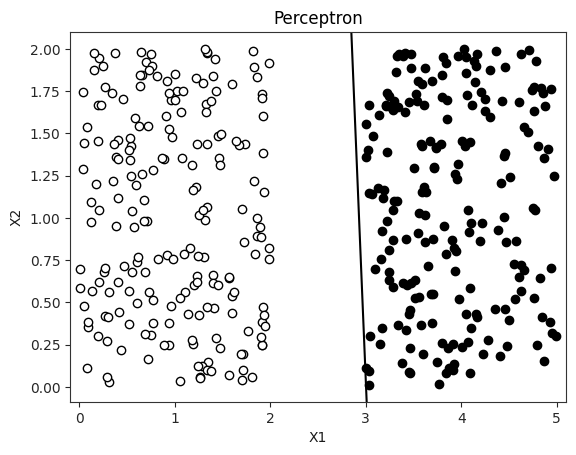

In [28]:
w_demo = train_perceptron(x, y, lr=0.1, epochs=2, bias=True, verbose=False)
plt.scatter(x[y==-1,0], x[y==-1,1], facecolors='1', edgecolors='0', label='Classe -1')
plt.scatter(x[y==1,0],  x[y==1,1],  facecolors='0', edgecolors='0', label='Classe +1')
plt.xlabel('X1'); plt.ylabel('X2')
plt.xlim(x[:,0].min()-.1, x[:,0].max()+.1)
plt.ylim(x[:,1].min()-.1, x[:,1].max()+.1)
xv = np.linspace(*plt.xlim(), 50)
yv = -(w_demo[0] + w_demo[1]*xv)/w_demo[2]
plt.plot(xv, yv, 'k', label='Separador')
plt.title('Perceptron')
plt.show()

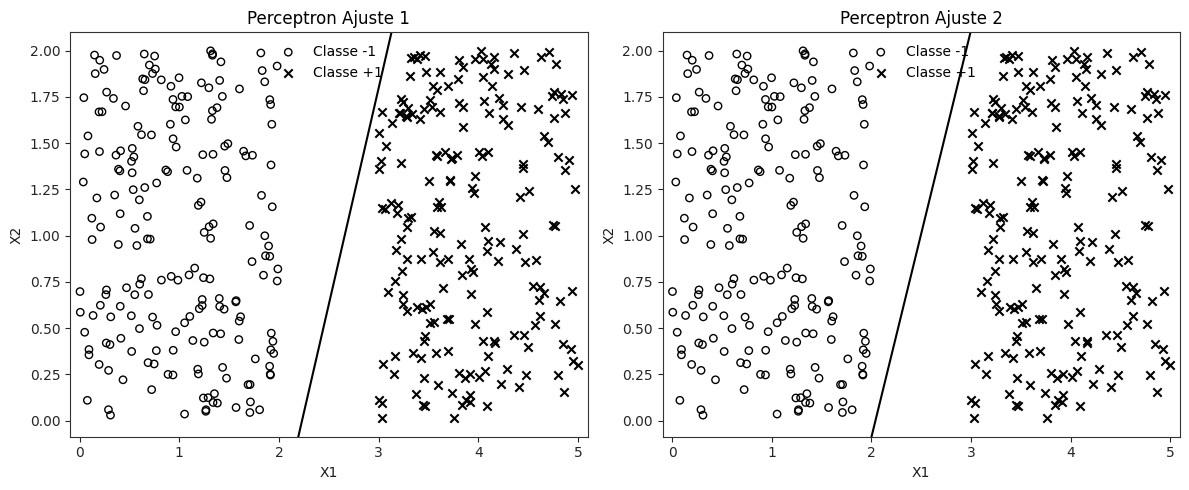

In [29]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
w1 = train_perceptron(x,y,lr=0.1,epochs=2,bias=True,verbose=False)
w2 = train_perceptron(x,y,lr=0.1,epochs=2,bias=True,verbose=False)
for ax, w, title in zip(axs, [w1,w2], ['Perceptron Ajuste 1','Perceptron Ajuste 2']):
    ax.scatter(x[y==-1,0], x[y==-1,1], facecolors='none', edgecolors='k', s=28, label='Classe -1')
    ax.scatter(x[y==1,0],  x[y==1,1],  c='k', marker='x', s=36, label='Classe +1')
    ax.set_xlim(x[:,0].min()-.1, x[:,0].max()+.1)
    ax.set_ylim(x[:,1].min()-.1, x[:,1].max()+.1)
    xv = np.linspace(*ax.get_xlim(), 50)
    yv = -(w[0] + w[1]*xv)/w[2]
    ax.plot(xv, yv, 'k')
    ax.set_title(title)
    ax.set_xlabel('X1'); ax.set_ylabel('X2')
    ax.legend(frameon=False)
plt.tight_layout(); plt.show()

## Seleção de índices candidatos (margem)

In [30]:
def select_closest_to_margin(X, y, w, k=0.1, bias=True):
    Xw = np.hstack([np.ones((X.shape[0],1)), X]) if bias else X
    idx0 = np.where(y==-1)[0]; idx1 = np.where(y==1)[0]
    d0 = np.abs(Xw[idx0] @ w)/np.linalg.norm(w[1:] if bias else w)
    d1 = np.abs(Xw[idx1] @ w)/np.linalg.norm(w[1:] if bias else w)
    n0 = max(1, int(len(idx0)*k)); n1 = max(1, int(len(idx1)*k))
    sel0 = idx0[np.argsort(d0)[:n0]]
    sel1 = idx1[np.argsort(d1)[:n1]]
    return np.hstack([sel0, sel1])

def select_by_perceptron_rounds(X, y, k=0.1, *, rounds=5, epochs_per_round=2, lr=0.1, bias=True, verbose=True):
    selected = set()
    for r in range(1, rounds+1):
        w = train_perceptron(X,y,lr=lr,epochs=epochs_per_round,bias=bias,verbose=False)
        new = select_closest_to_margin(X,y,w,k=k,bias=bias)
        before = len(selected)
        for i in new: selected.add(int(i))
        if verbose:
            print(f'Rodada {r}: +{len(selected)-before} (total {len(selected)})')
    return np.array(sorted(selected), dtype=int)

## Construção dos Grafos (completo e reduzido)

In [31]:
#Tempo de construção do grafo Gabriel completo

t0 = time.time()
G1 = gg.GabrielGraph(device='cpu')
G1.build(x, y)
t1 = time.time()
print(f'Tempo construção G1: {t1-t0:.4f}s')

#Seleção dos pontos mais próximos da margem
sel_ind = select_by_perceptron_rounds(x,y,k=0.05,rounds=15,epochs_per_round=2,lr=0.1,bias=True,verbose=False)
x_sel = x[sel_ind]; y_sel = y[sel_ind]
print(f'Selected {len(x_sel)} / {len(x)}')

#Tempo de construção do grafo Gabriel reduzido
G2 = gg.GabrielGraph(device='cpu')
G2.build(x_sel, y_sel)
t2 = time.time()
print(f'Tempo construção G2: {t2-t1:.4f}s')

edges = list(G1.edges()); num_edges = len(edges)
edges2 = list(G2.edges()); num_edges2 = len(edges2)
# If you ever need to convert to numpy array, use dtype=object:
edges_np = np.array(edges, dtype=object)
edges2_np = np.array(edges2, dtype=object)

Tempo construção G1: 0.1519s
Selected 47 / 400
Tempo construção G2: 0.0158s


In [32]:
#Comparação dos grafos

common_indices = np.array(sel_ind, dtype=int)
print(f'Total completo: {x.shape[0]} | reduzido: {len(common_indices)}')
support_vertices_full = set()
for i,j in G1.support_edges():
    support_vertices_full.add(int(i)); support_vertices_full.add(int(j))
support_vertices_sub = set()
for i,j in G2.support_edges():
    support_vertices_sub.add(int(sel_ind[i])); support_vertices_sub.add(int(sel_ind[j]))
inter_support = support_vertices_full & support_vertices_sub
print(f'Suporte full: {len(support_vertices_full)} | suporte sub: {len(support_vertices_sub)} | interseção: {len(inter_support)}')
if support_vertices_full:
    print(f'Cobertura: {100*len(inter_support)/len(support_vertices_full):.2f}%')

Total completo: 400 | reduzido: 47
Suporte full: 14 | suporte sub: 14 | interseção: 14
Cobertura: 100.00%


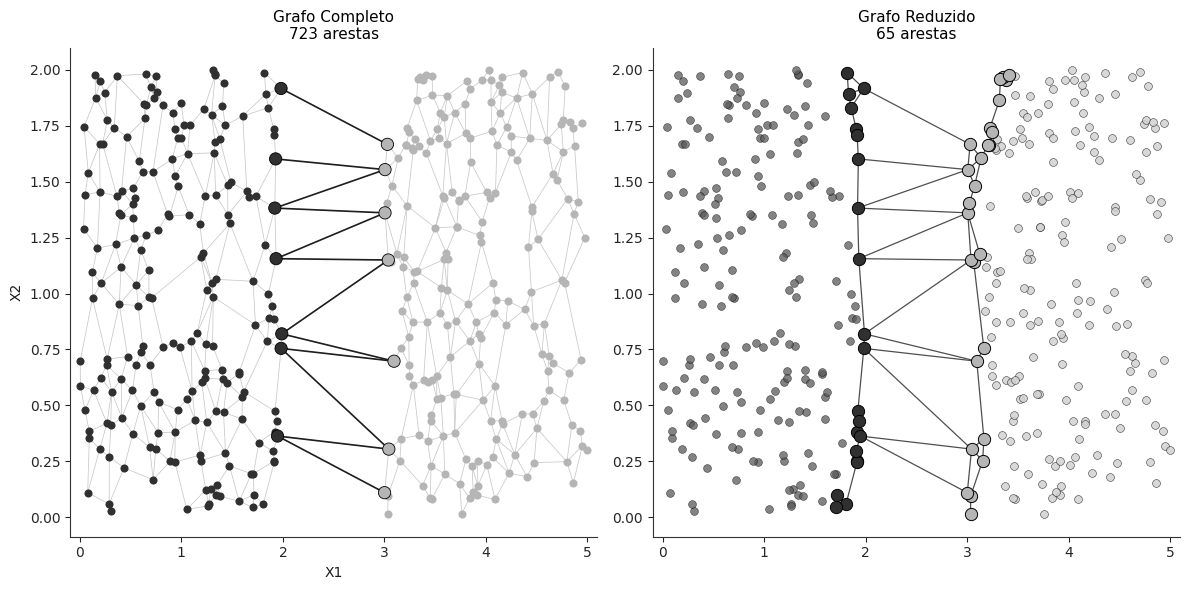

In [33]:
import matplotlib as mpl
mpl.rcParams.update({'axes.edgecolor':'0.2','axes.labelcolor':'0.1','xtick.color':'0.15','ytick.color':'0.15'})
color_neg='#303030'; color_pos='#b5b5b5'
non_mask = np.ones(len(x), dtype=bool); non_mask[sel_ind]=False
x_non = x[non_mask]; y_non = y[non_mask]
fig, axs = plt.subplots(1,2, figsize=(12,6))
# Painel 1
ax = axs[0]
ax.set_title(f'Grafo Completo\n{num_edges} arestas', fontsize=11)
for (i,j) in edges:
    ax.plot([x[i,0],x[j,0]],[x[i,1],x[j,1]],color='#c8c8c8',lw=0.55,zorder=0)
sup_edges_full = list(G1.support_edges())
sup_vertices_full = set()
for i,j in sup_edges_full:
    ax.plot([x[i,0],x[j,0]],[x[i,1],x[j,1]],color='#1f1f1f',lw=1.2,zorder=1)
    sup_vertices_full.add(int(i)); sup_vertices_full.add(int(j))
ax.scatter(x[y==-1,0],x[y==-1,1],s=34,c=color_neg,edgecolors='k',linewidths=0,label='Classe -1',zorder=2)
ax.scatter(x[y==1,0], x[y==1,1], s=34,c=color_pos,edgecolors='k',linewidths=0,label='Classe +1',zorder=2)
sup_vertices_full = np.array(list(sup_vertices_full))
if len(sup_vertices_full):
    ax.scatter(x[sup_vertices_full,0],x[sup_vertices_full,1],
               s=78,c=[color_neg if yy==-1 else color_pos for yy in y[sup_vertices_full]],
               edgecolors='k',linewidths=0.6,zorder=3)
ax.set_xlabel('X1'); ax.set_ylabel('X2')
# Painel 2
ax = axs[1]
ax.set_title(f'Grafo Reduzido\n{num_edges2} arestas', fontsize=11)
ax.scatter(x_non[y_non==-1,0],x_non[y_non==-1,1],s=32,c='#5a5a5a',edgecolors='k',linewidths=0.35,alpha=0.75,label='-1 (não sel.)',zorder=0)
ax.scatter(x_non[y_non==1,0], x_non[y_non==1,1], s=32,c='#d2d2d2',edgecolors='k',linewidths=0.35,alpha=0.85,label='+1 (não sel.)',zorder=0)
for (i,j) in edges2:
    ax.plot([x_sel[i,0],x_sel[j,0]],[x_sel[i,1],x_sel[j,1]],color='#4f4f4f',lw=0.9,zorder=1)
ax.scatter(x_sel[y_sel==-1,0],x_sel[y_sel==-1,1],s=78,c=color_neg,edgecolors='k',linewidths=0.7,label='-1 (sel.)',zorder=2)
ax.scatter(x_sel[y_sel==1,0], x_sel[y_sel==1,1], s=78,c=color_pos,edgecolors='k',linewidths=0.7,label='+1 (sel.)',zorder=2)
for ax in axs:
    ax.set_xlim(x[:,0].min()-.1, x[:,0].max()+.1)
    ax.set_ylim(x[:,1].min()-.1, x[:,1].max()+.1)
    for sp in ['top','right']: ax.spines[sp].set_visible(False)

plt.tight_layout(); plt.show()
fig.savefig('gabriel_graph_comparison.png', dpi=300)

In [34]:
support_edges = list(G1.support_edges())
hyperplanes = []
for (i,j) in support_edges:
    mid = (G1.X[i] + G1.X[j]) / 2.0
    normal = G1.X[j] - G1.X[i]
    hyperplanes.append((mid, normal))
print(f'Hiperplanos (full): {len(hyperplanes)}')

Hiperplanos (full): 12


In [35]:
def local_hyperplane_classifier(p, planes, sigma=1.0):
    """
    p: (d,)
    planes: lista de (mid, normal) já orientados (lado positivo => classe +1)
    """
    if not planes:
        return 0
    p = np.asarray(p, float)
    votes = []
    weights = []
    for mid, normal in planes:
        mid = np.asarray(mid)
        normal = np.asarray(normal)
        raw = (p - mid) @ normal
        # voto: sinal direto (porque normal já orientada)
        vote = 1 if raw >= 0 else -1
        # distância ao plano (margem geométrica)
        margin = abs(raw) / (np.linalg.norm(normal) + 1e-12)
        # peso: gaussiano inverso (maior peso se p mais próximo do plano)
        w = np.exp(- (margin**2) / (2 * sigma**2))
        votes.append(vote)
        weights.append(w)
    weights = np.array(weights)
    if weights.sum() == 0:
        weights = np.ones_like(weights)
    weights /= weights.sum()
    score = np.dot(weights, votes)
    return 1 if score >= 0 else -1

def build_oriented_hyperplanes(G):
    planes = []
    # Assume G.X (n,d) e G.y (n,) em {-1,+1}
    for (i, j) in G.support_edges():
        yi, yj = G.y[i], G.y[j]
        if yi == yj:
            continue  # só interessa separar classes distintas
        mid = (G.X[i] + G.X[j]) / 2.0
        normal = G.X[j] - G.X[i]  # vetor i -> j
        # Orienta normal para que lado positivo seja classe +1
        # Queremos (p-mid)·normal > 0 => predição +1
        # Se o ponto j for -1 e i for +1, inverte:
        if yj == -1 and yi == 1:
            normal = -normal
        # Se (yi,yj)=(-1,+1) fica como está; se (+1,-1) foi invertido.
        planes.append((mid, normal))
    return planes

## Criação de fronteira de decisão

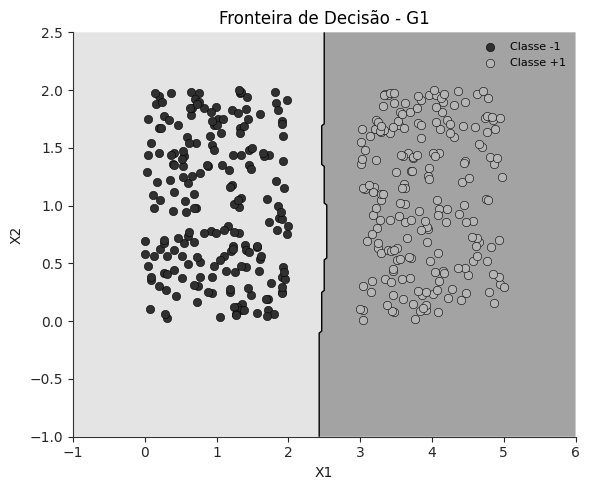

In [36]:



xx, yy = np.meshgrid(np.linspace(-1,6,200), np.linspace(-1,2.5,200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([local_hyperplane_classifier(p, hyperplanes) for p in grid]).reshape(xx.shape)
color_neg='#303030'; color_pos='#b5b5b5'; region_neg='#d9d9d9'; region_pos='#7d7d7d'
fig, ax = plt.subplots(figsize=(6,5))
ax.contourf(xx, yy, Z, levels=[-1,0,1], colors=[region_neg, region_pos], alpha=0.70, antialiased=True)
ax.contour(xx, yy, Z, levels=[0], colors='k', linewidths=1.0)
ax.scatter(x[y==-1,0], x[y==-1,1], s=36, c=color_neg, edgecolors='k', linewidths=0.4, label='Classe -1')
ax.scatter(x[y==1,0],  x[y==1,1],  s=36, c=color_pos, edgecolors='k', linewidths=0.4, label='Classe +1')
ax.set_title('Fronteira de Decisão - G1')
ax.set_xlabel('X1'); ax.set_ylabel('X2')
for sp in ['top','right']: ax.spines[sp].set_visible(False)
ax.legend(frameon=False, fontsize=8)
plt.tight_layout(); plt.show()
fig.savefig('decision_boundary_g1.png', dpi=300)

## Exeperimentos comparando a técnica porposta com regressão logística e com o perceptron simples

### Dados 2D


In [37]:
# Criação de dados sintéticos para treinamento
x_train, y_train = parallel_stripes(200,distance=3.5)

#Força os dados a ficarem mais próximos
X_test, y_test = parallel_stripes(70,distance=2.7)

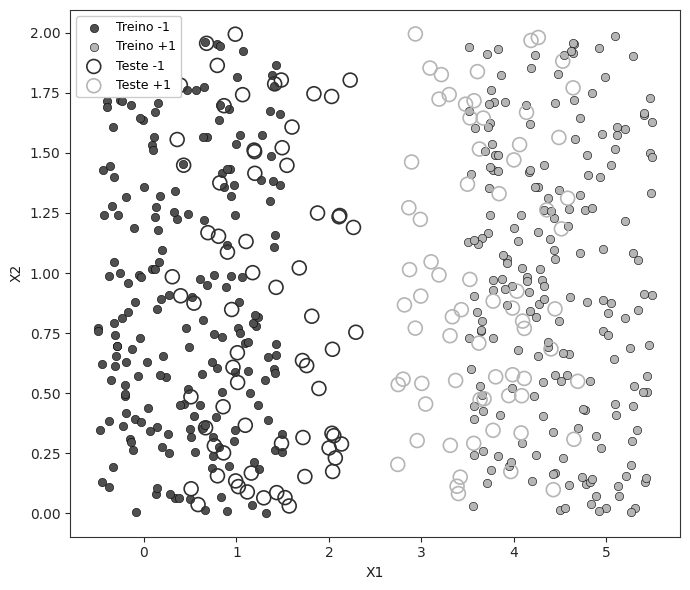

In [38]:
fig, ax = plt.subplots(figsize=(7,6))
# Dados de treino
ax.scatter(x_train[y_train==-1,0], x_train[y_train==-1,1], s=36, c='#505050', edgecolors='k', linewidths=0.4, label='Treino -1')
ax.scatter(x_train[y_train==1,0],  x_train[y_train==1,1],  s=36, c='#b5b5b5', edgecolors='k', linewidths=0.4, label='Treino +1')
# Dados de teste
ax.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], s=100, facecolors='none', edgecolors='#303030', linewidths=1.2, label='Teste -1',marker='o')
ax.scatter(X_test[y_test==1,0],  X_test[y_test==1,1], s=100, facecolors='none', edgecolors='#b5b5b5', linewidths=1.2, label='Teste +1',marker='o')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
plt.legend(loc='upper left', frameon=True, framealpha=1.0, fontsize=9)
plt.tight_layout()
plt.show()

fig.savefig('train_test_selection.png', dpi=300)


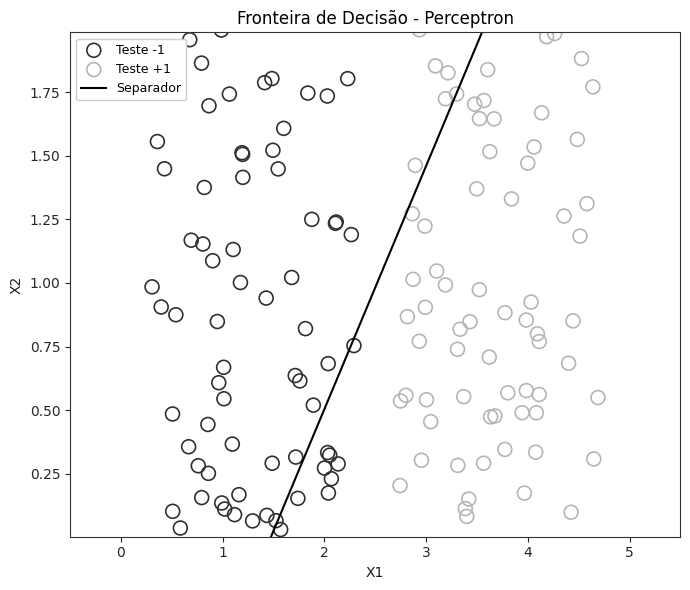

Acurácia do Perceptron: 90.00%


In [39]:
#Ajuste do perceptron
w_demo = train_perceptron(x_train, y_train, lr=0.1, epochs=10, bias=True, verbose=False)



fig, ax = plt.subplots(figsize=(7,6))

ax.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], s=100, facecolors='none', edgecolors='#303030', linewidths=1.2, label='Teste -1',marker='o')
ax.scatter(X_test[y_test==1,0],  X_test[y_test==1,1], s=100, facecolors='none', edgecolors='#b5b5b5', linewidths=1.2, label='Teste +1',marker='o')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_xlim(x_train[:,0].min(), x_train[:,0].max())
ax.set_ylim(x_train[:,1].min(), x_train[:,1].max())
#Plot do separador
xv = np.linspace(*plt.xlim(), 50)
yv = -(w_demo[0] + w_demo[1]*xv)/w_demo[2]
plt.plot(xv, yv, 'k', label='Separador')
plt.title('Fronteira de Decisão - Perceptron')
plt.legend(loc='upper left', frameon=True, framealpha=1.0, fontsize=9)
plt.tight_layout()
plt.show()

#Acurácia do perceptron
y_pred = np.array([np.sign(np.hstack(([1], x)) @ w_demo) for x in X_test])

metrics_parallel_stripes_perceptron_accuracy = (y_pred == y_test).mean()
print(f'Acurácia do Perceptron: {metrics_parallel_stripes_perceptron_accuracy*100:.2f}%')

Acurácia da Regressão Logística: 100.00%


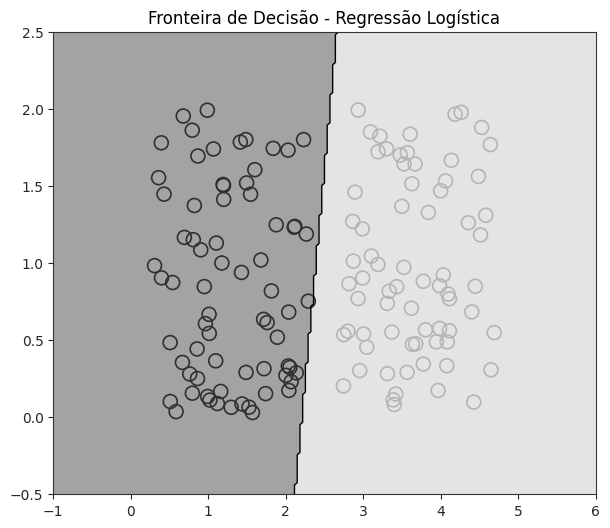

In [40]:
#Ajuste de regressão logística
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty=None, fit_intercept=True, max_iter=200)
model.fit(x_train, y_train)
y_pred_lr = model.predict(X_test)

#Acurácia da regressão logística
metrics_parallel_stripes_logreg_accuracy = (y_pred_lr == y_test).mean()
print(f'Acurácia da Regressão Logística: {metrics_parallel_stripes_logreg_accuracy*100:.2f}%')

#Plot da regiao de decisão
xx, yy = np.meshgrid(np.linspace(-1,6,200), np.linspace(-0.5,2.5,200))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid).reshape(xx.shape)
color_neg='#303030'; color_pos='#b5b5b5'; region_neg='#d9d9d9'; region_pos='#7d7d7d'
fig, ax = plt.subplots(figsize=(7,6))
ax.contourf(xx, yy, Z, levels=[-1,0,1], colors=[region_pos, region_neg], alpha=0.70, antialiased=True)
ax.contour(xx, yy, Z, levels=[0], colors='k', linewidths=1.0)
#ax.scatter(x_train[y_train==-1,0], x_train[y_train==-1,1], s=36, c='#505050', edgecolors='k', linewidths=0.4, label='Treino -1')
#ax.scatter(x_train[y_train==1,0],  x_train[y_train==1,1],  s=36, c='#b5b5b5', edgecolors='k', linewidths=0.4, label='Treino +1')
ax.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], s=100, facecolors='none', edgecolors='#303030', linewidths=1.2, label='Teste -1',marker='o')
ax.scatter(X_test[y_test==1,0],  X_test[y_test==1,1], s=100, facecolors='none', edgecolors='#b5b5b5', linewidths=1.2, label='Teste +1',marker='o')
ax.set_title('Fronteira de Decisão - Regressão Logística')

#Salva o gráfico
plt.savefig('decision_boundary_logistic_regression.png', dpi=300)

Hiperplanos (full): 7
Acurácia do Classificador Gabriel: 100.00%


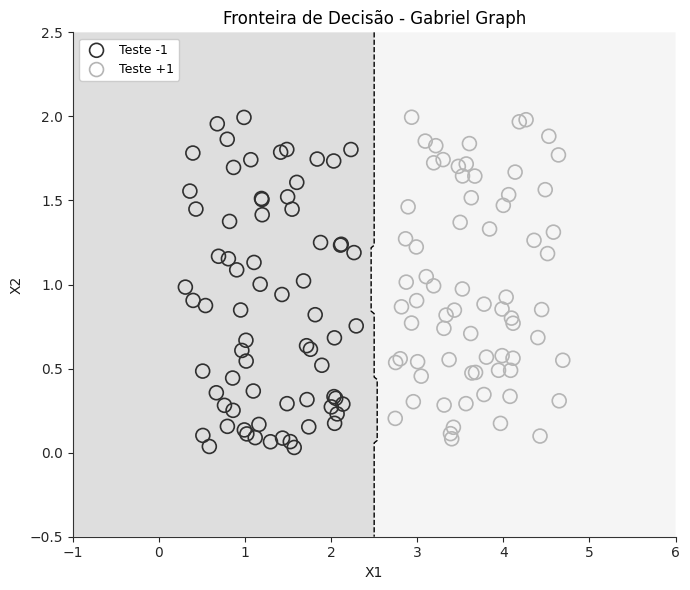

In [41]:
#Ajuste do separador baseado em grafos Gabriel
G3 = gg.GabrielGraph(device='cpu')
G3.build(x_train, y_train)
support_edges = list(G3.support_edges())
hyperplanes = []
for (i,j) in support_edges:
    mid = (G3.X[i] + G3.X[j]) / 2.0
    normal = G3.X[j] - G3.X[i]
    hyperplanes.append((mid, normal))
print(f'Hiperplanos (full): {len(hyperplanes)}')

#Acurácia do classificador baseado em grafos Gabriel
y_pred_gg = np.array([local_hyperplane_classifier(p, hyperplanes) for p in X_test])
metrics_parallel_stripes_gabriel_accuracy = (y_pred_gg == y_test).mean()
print(f'Acurácia do Classificador Gabriel: {metrics_parallel_stripes_gabriel_accuracy*100:.2f}%')

# Plot da fronteira de decisão + conjunto teste
fig, ax = plt.subplots(figsize=(7,6))
Z = np.array([local_hyperplane_classifier(p, hyperplanes) for p in grid]).reshape(xx.shape)
ax.contourf(xx, yy, Z, levels=[-1,0,1], colors=[region_pos, region_neg], alpha=0.25, antialiased=True)
ax.contour(xx, yy, Z, levels=[0], colors='k', linewidths=1.0, linestyles='dashed')
#ax.scatter(x_train[y_train==-1,0], x_train[y_train==-1,1], s=36, c='#505050', edgecolors='k', linewidths=0.4, label='Treino -1')
#ax.scatter(x_train[y_train==1,0],  x_train[y_train==1,1],  s=36, c='#b5b5b5', edgecolors='k', linewidths=0.4, label='Treino +1')
ax.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], s=100, facecolors='none', edgecolors='#303030', linewidths=1.2, label='Teste -1',marker='o')
ax.scatter(X_test[y_test==1,0],  X_test[y_test==1,1], s=100, facecolors='none', edgecolors='#b5b5b5', linewidths=1.2, label='Teste +1',marker='o')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('Fronteira de Decisão - Gabriel Graph')
for sp in ['top','right']: ax.spines[sp].set_visible(False)
plt.legend(loc='upper left', frameon=True, framealpha=1.0, fontsize=9)
plt.tight_layout()
plt.show()

fig.savefig('decision_boundary_gabriel_graph_test.png', dpi=300)

## Comparação de resultados para dados multivariados e linearmente separáveis.

### Conjunto IRIS

In [42]:
#Carrega o IRIS dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target

#Filtra apenas duas classes 
mask = y != 1
X = X[mask]
y = y[mask]

y = np.where(y==0, -1, 1)  # Converte labels de {0,1} para {-1,1}

# Re-divisão correta (a célula anterior tinha ordem trocada)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
print(f'Treino: {X_train.shape}, Teste: {X_test.shape}')


Treino: (70, 4), Teste: (30, 4)


In [43]:

# -------- Perceptron --------
w_iris = train_perceptron(X_train, y_train, lr=0.05, epochs=40, bias=True, verbose=False)
Xw_test = np.hstack([np.ones((X_test.shape[0],1)), X_test])
y_pred_perc = np.sign(Xw_test @ w_iris)
metrics_iris_perceptron_accuracy = (y_pred_perc == y_test).mean()

# -------- Regressão Logística (sem penalização) --------
logreg = LogisticRegression(penalty=None, fit_intercept=True, max_iter=1000)
logreg.fit(X_train, y_train)
metrics_iris_logreg_accuracy = (logreg.predict(X_test) == y_test).mean()

# -------- Classificador Grafo de Gabriel --------
G_iris = gg.GabrielGraph(device='cpu')
G_iris.build(X_train, y_train)

hyp_iris = build_oriented_hyperplanes(G_iris)
y_pred_gg = np.array([local_hyperplane_classifier(p, hyp_iris) for p in X_test])
metrics_iris_gabriel_accuracy = (y_pred_gg == y_test).mean()

#---------- Seleção de instâncias mais relevantes com Perceptron --------
sel_ind_iris = select_by_perceptron_rounds(
    X_train, y_train,
    k=0.1,
    rounds=100,
    epochs_per_round=10,
    lr=0.05,
    bias=True,
    verbose=False
)
X_train_red = X_train[sel_ind_iris]
y_train_red = y_train[sel_ind_iris]
print(f'Treino full: {len(X_train)} | reduzido: {len(X_train_red)} ({100*len(X_train_red)/len(X_train):.2f}%)')

G_iris_red = gg.GabrielGraph(device='cpu')
G_iris_red.build(X_train_red, y_train_red)

# 3. Hiperplanos reduzidos
hyp_iris_red = build_oriented_hyperplanes(G_iris_red)
# 4. Acurácia do classificador reduzido

y_pred_gg_red = np.array([local_hyperplane_classifier(p, hyp_iris_red) for p in X_test])
metrics_iris_gabriel_reduced_accuracy = (y_pred_gg_red == y_test).mean()
print(f'Acurácia Gabriel Reduzido: {metrics_iris_gabriel_reduced_accuracy*100:.2f}%')

#Comparação dos grafos
common_indices = np.array(sel_ind_iris, dtype=int)
print(f'Total completo: {X.shape[0]} | reduzido: {len(common_indices)}')
support_vertices_full = set()
for i,j in G_iris.support_edges():
    support_vertices_full.add(int(i)); support_vertices_full.add(int(j))
support_vertices_sub = set()
for i,j in G_iris_red.support_edges():
    support_vertices_sub.add(int(sel_ind_iris[i])); support_vertices_sub.add(int(sel_ind_iris[j]))
inter_support = support_vertices_full & support_vertices_sub
print(f'Suporte full: {len(support_vertices_full)} | suporte sub: {len(support_vertices_sub)} | interseção: {len(inter_support)}')
if support_vertices_full:
    print(f'Cobertura: {100*len(inter_support)/len(support_vertices_full):.2f}%')

# -------- Tabela de Resultados --------
results = pd.DataFrame([
    {'Modelo':'Perceptron', 'Acuracia_Test': metrics_iris_perceptron_accuracy},
    {'Modelo':'Regressão Logística (none)', 'Acuracia_Test': metrics_iris_logreg_accuracy},
    {'Modelo':'Grafo Gabriel (hiperplanos locais)', 'Acuracia_Test': metrics_iris_gabriel_accuracy},
    {'Modelo':'Grafo Gabriel Reduzido', 'Acuracia_Test': metrics_iris_gabriel_reduced_accuracy}
])
results['Acuracia_Test'] = (100*results['Acuracia_Test']).round(2)
print(results.to_string(index=False))


Treino full: 70 | reduzido: 41 (58.57%)
Acurácia Gabriel Reduzido: 100.00%
Total completo: 100 | reduzido: 41
Suporte full: 2 | suporte sub: 2 | interseção: 2
Cobertura: 100.00%
                            Modelo  Acuracia_Test
                        Perceptron          100.0
        Regressão Logística (none)          100.0
Grafo Gabriel (hiperplanos locais)          100.0
            Grafo Gabriel Reduzido          100.0


### Conjunto BreastCancer

In [44]:
#Importa o conjunto Breast Cancer Wisconsin (Diagnostic)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dados = pd.read_csv('C:\\Users\\felip\\Projetos Python\\Redes Neurais Mestrado\\DataSets\\Breast_Cancer.csv')
dados = dados.drop(columns=['Unnamed: 0'])
dados = dados.dropna()
X = dados.drop(columns=['Id', 'Class']).values
y = dados['Class'].map({'malignant':-1, 'benign':1}).values
print(f'Dados: {X.shape}, Labels: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=2025, stratify=y
)
print(f'Treino: {X_train.shape}, Teste: {X_test.shape}')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Dados: (683, 9), Labels: (683,)
Treino: (478, 9), Teste: (205, 9)


In [45]:
# -------- Perceptron --------
w_bc = train_perceptron(X_train, y_train, lr=0.0005, epochs=100, bias=True, verbose=False)
Xw_test = np.hstack([np.ones((X_test.shape[0],1)), X_test])
y_pred_perc = np.sign(Xw_test @ w_bc)
metrics_bc_perceptron_accuracy = (y_pred_perc == y_test).mean()

# -------- Regressão Logística (sem penalização) --------
logreg = LogisticRegression(penalty=None, fit_intercept=True, max_iter=1000)
logreg.fit(X_train, y_train)
metrics_bc_logreg_accuracy = (logreg.predict(X_test) == y_test).mean()

# -------- Classificador Grafo de Gabriel --------
G_bc = gg.GabrielGraph(device='cpu')
G_bc.build(X_train, y_train)
hyp_bc = build_oriented_hyperplanes(G_bc)
y_pred_gg = np.array([local_hyperplane_classifier(p, hyp_bc) for p in X_test])
metrics_bc_gabriel_accuracy = (y_pred_gg == y_test).mean()

#---------- Seleção de instâncias mais relevantes com Perceptron --------
sel_ind_bc = select_by_perceptron_rounds(
    X_train, y_train,
    k=0.05,
    rounds=15,
    epochs_per_round=30,
    lr=0.05,
    bias=True,
    verbose=False
)
X_train_red = X_train[sel_ind_bc]
y_train_red = y_train[sel_ind_bc]

G_bc_red = gg.GabrielGraph(device='cpu')
G_bc_red.build(X_train_red, y_train_red)
hyp_bc_red = build_oriented_hyperplanes(G_bc_red)
y_pred_gg_red = np.array([local_hyperplane_classifier(p, hyp_bc_red) for p in X_test])
metrics_bc_gabriel_reduced_accuracy = (y_pred_gg_red == y_test).mean()

# Comparação dos grafos
common_indices = np.array(sel_ind_bc, dtype=int)
support_vertices_full = set()
for i,j in G_bc.support_edges():
    support_vertices_full.add(int(i)); support_vertices_full.add(int(j))
support_vertices_sub = set()
for i,j in G_bc_red.support_edges():
    support_vertices_sub.add(int(sel_ind_bc[i])); support_vertices_sub.add(int(sel_ind_bc[j]))
inter_support = support_vertices_full & support_vertices_sub
metrics_bc_support_coverage = 100*len(inter_support)/len(support_vertices_full) if support_vertices_full else 0.0

# -------- Tabela de Resultados --------
import pandas as pd
results_bc = pd.DataFrame([
    {'Modelo':'Perceptron', 'Acuracia_Test': metrics_bc_perceptron_accuracy},
    {'Modelo':'Regressão Logística (none)', 'Acuracia_Test': metrics_bc_logreg_accuracy},
    {'Modelo':'Grafo Gabriel (hiperplanos locais)', 'Acuracia_Test': metrics_bc_gabriel_accuracy},
    {'Modelo':'Grafo Gabriel Reduzido', 'Acuracia_Test': metrics_bc_gabriel_reduced_accuracy}
])
results_bc['Acuracia_Test'] = (100*results_bc['Acuracia_Test']).round(2)
print(results_bc.to_string(index=False))
print(f'Treino full: {len(X_train)} | reduzido: {len(X_train_red)} ({100*len(X_train_red)/len(X_train):.2f}%)')
print(f'Total completo: {X_train.shape[0]} | reduzido: {len(common_indices)}')
print(f'Suporte full: {len(support_vertices_full)} | suporte sub: {len(support_vertices_sub)} | interseção: {len(inter_support)}')
if support_vertices_full:
    print(f'Cobertura: {metrics_bc_support_coverage:.2f}%')


                            Modelo  Acuracia_Test
                        Perceptron          95.12
        Regressão Logística (none)          96.10
Grafo Gabriel (hiperplanos locais)          93.17
            Grafo Gabriel Reduzido          94.15
Treino full: 478 | reduzido: 72 (15.06%)
Total completo: 478 | reduzido: 72
Suporte full: 142 | suporte sub: 66 | interseção: 64
Cobertura: 45.07%


In [48]:
# Conjunto 1
rng = np.random.RandomState(101)
n, d, inf, ruido, margem = 400, 12, 5, 7, 1.0
X_inf = rng.randn(n, inf)
w_dir = rng.randn(inf); w_dir /= np.linalg.norm(w_dir)
proj = X_inf @ w_dir
ajuste = (margem - np.abs(proj[np.abs(proj)<margem]))
if ajuste.size > 0:
    X_inf[np.abs(proj)<margem] += np.outer(np.sign(proj[np.abs(proj)<margem]), w_dir) * ajuste[:,None]
    proj = X_inf @ w_dir
y1 = np.where(proj >= 0, 1, -1)
X_ruido = rng.randn(n, ruido)
X1 = np.hstack([X_inf, X_ruido])
perm = rng.permutation(n)
X1 = X1[perm]; y1 = y1[perm]

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify=y1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

w1 = train_perceptron(X_train, y_train, lr=0.05, epochs=80, bias=True, verbose=False)
Xw_test = np.hstack([np.ones((X_test.shape[0],1)), X_test])
y_pred_perc = np.sign(Xw_test @ w1)
metrics_syn1_perceptron_accuracy = (y_pred_perc == y_test).mean()

logreg = LogisticRegression(penalty=None, fit_intercept=True, max_iter=1000)
logreg.fit(X_train, y_train)
metrics_syn1_logreg_accuracy = (logreg.predict(X_test) == y_test).mean()

G_full = gg.GabrielGraph(device='cpu')
G_full.build(X_train, y_train)
hyp_full = build_oriented_hyperplanes(G_full)
y_pred_gg = np.array([local_hyperplane_classifier(p, hyp_full) for p in X_test])
metrics_syn1_gabriel_accuracy = (y_pred_gg == y_test).mean()

sel_ind = select_by_perceptron_rounds(X_train, y_train, k=0.1, rounds=20, epochs_per_round=15, lr=0.05, bias=True, verbose=False)
X_train_red = X_train[sel_ind]
y_train_red = y_train[sel_ind]
G_red = gg.GabrielGraph(device='cpu')
G_red.build(X_train_red, y_train_red)
hyp_red = build_oriented_hyperplanes(G_red)
y_pred_gg_red = np.array([local_hyperplane_classifier(p, hyp_red) for p in X_test])
metrics_syn1_gabriel_reduced_accuracy = (y_pred_gg_red == y_test).mean()

prop1 = len(sel_ind)/len(X_train[0])

support_vertices_full = set()
for i,j in G_full.support_edges():
    support_vertices_full.add(int(i)); support_vertices_full.add(int(j))
support_vertices_sub = set()
for i,j in G_red.support_edges():
    support_vertices_sub.add(int(sel_ind[i])); support_vertices_sub.add(int(sel_ind[j]))
inter_support = support_vertices_full & support_vertices_sub
metrics_syn1_support_coverage = 100*len(inter_support)/len(support_vertices_full) if support_vertices_full else 0.0

import pandas as pd
results1 = pd.DataFrame([
    {'Modelo':'Perceptron', 'Acuracia_Test': metrics_syn1_perceptron_accuracy},
    {'Modelo':'Regressão Logística (none)', 'Acuracia_Test': metrics_syn1_logreg_accuracy},
    {'Modelo':'Grafo Gabriel (hiperplanos locais)', 'Acuracia_Test': metrics_syn1_gabriel_accuracy},
    {'Modelo':'Grafo Gabriel Reduzido', 'Acuracia_Test': metrics_syn1_gabriel_reduced_accuracy}
])
results1['Acuracia_Test'] = (100*results1['Acuracia_Test']).round(2)
print('Conjunto 1:')
print(results1.to_string(index=False))
print(f'Cobertura Conjunto 1: {metrics_syn1_support_coverage:.2f}%')
# Conjunto 2
rng = np.random.RandomState(202)
n, d, inf, ruido, margem = 450, 16, 6, 10, 1.2
X_inf = rng.randn(n, inf)
w_dir = rng.randn(inf); w_dir /= np.linalg.norm(w_dir)
proj = X_inf @ w_dir
ajuste = (margem - np.abs(proj[np.abs(proj)<margem]))
if ajuste.size > 0:
    X_inf[np.abs(proj)<margem] += np.outer(np.sign(proj[np.abs(proj)<margem]), w_dir) * ajuste[:,None]
    proj = X_inf @ w_dir
y2 = np.where(proj >= 0, 1, -1)
X_ruido = rng.randn(n, ruido)
X2 = np.hstack([X_inf, X_ruido])
perm = rng.permutation(n)
X2 = X2[perm]; y2 = y2[perm]

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify=y2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

w2 = train_perceptron(X_train, y_train, lr=0.04, epochs=90, bias=True, verbose=False)
Xw_test = np.hstack([np.ones((X_test.shape[0],1)), X_test])
y_pred_perc = np.sign(Xw_test @ w2)
metrics_syn2_perceptron_accuracy = (y_pred_perc == y_test).mean()

logreg = LogisticRegression(penalty=None, fit_intercept=True, max_iter=1000)
logreg.fit(X_train, y_train)
metrics_syn2_logreg_accuracy = (logreg.predict(X_test) == y_test).mean()

G_full = gg.GabrielGraph(device='cpu')
G_full.build(X_train, y_train)
hyp_full = build_oriented_hyperplanes(G_full)
y_pred_gg = np.array([local_hyperplane_classifier(p, hyp_full) for p in X_test])
metrics_syn2_gabriel_accuracy = (y_pred_gg == y_test).mean()

sel_ind = select_by_perceptron_rounds(X_train, y_train, k=0.10, rounds=40, epochs_per_round=15, lr=0.05, bias=True, verbose=False)
X_train_red = X_train[sel_ind]
y_train_red = y_train[sel_ind]
G_red = gg.GabrielGraph(device='cpu')
G_red.build(X_train_red, y_train_red)
hyp_red = build_oriented_hyperplanes(G_red)
y_pred_gg_red = np.array([local_hyperplane_classifier(p, hyp_red) for p in X_test])
metrics_syn2_gabriel_reduced_accuracy = (y_pred_gg_red == y_test).mean()

prop2 = len(sel_ind)/len(X_train[0])

support_vertices_full = set()
for i,j in G_full.support_edges():
    support_vertices_full.add(int(i)); support_vertices_full.add(int(j))
support_vertices_sub = set()
for i,j in G_red.support_edges():
    support_vertices_sub.add(int(sel_ind[i])); support_vertices_sub.add(int(sel_ind[j]))
inter_support = support_vertices_full & support_vertices_sub
metrics_syn2_support_coverage = 100*len(inter_support)/len(support_vertices_full) if support_vertices_full else 0.0

results2 = pd.DataFrame([
    {'Modelo':'Perceptron', 'Acuracia_Test': metrics_syn2_perceptron_accuracy},
    {'Modelo':'Regressão Logística (none)', 'Acuracia_Test': metrics_syn2_logreg_accuracy},
    {'Modelo':'Grafo Gabriel (hiperplanos locais)', 'Acuracia_Test': metrics_syn2_gabriel_accuracy},
    {'Modelo':'Grafo Gabriel Reduzido', 'Acuracia_Test': metrics_syn2_gabriel_reduced_accuracy}
])
results2['Acuracia_Test'] = (100*results2['Acuracia_Test']).round(2)
print('Conjunto 2:')
print(results2.to_string(index=False))

# Conjunto 3
rng = np.random.RandomState(303)
n, d, inf, ruido, margem = 500, 20, 8, 12, 1.3
X_inf = rng.randn(n, inf)
w_dir = rng.randn(inf); w_dir /= np.linalg.norm(w_dir)
proj = X_inf @ w_dir
ajuste = (margem - np.abs(proj[np.abs(proj)<margem]))
if ajuste.size > 0:
    X_inf[np.abs(proj)<margem] += np.outer(np.sign(proj[np.abs(proj)<margem]), w_dir) * ajuste[:,None]
    proj = X_inf @ w_dir
y3 = np.where(proj >= 0, 1, -1)
X_ruido = rng.randn(n, ruido)
X3 = np.hstack([X_inf, X_ruido])
perm = rng.permutation(n)
X3 = X3[perm]; y3 = y3[perm]

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.3, random_state=42, stratify=y3)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

w3 = train_perceptron(X_train, y_train, lr=0.035, epochs=110, bias=True, verbose=False)
Xw_test = np.hstack([np.ones((X_test.shape[0],1)), X_test])
y_pred_perc = np.sign(Xw_test @ w3)
metrics_syn3_perceptron_accuracy = (y_pred_perc == y_test).mean()

logreg = LogisticRegression(penalty=None, fit_intercept=True, max_iter=1000)
logreg.fit(X_train, y_train)
metrics_syn3_logreg_accuracy = (logreg.predict(X_test) == y_test).mean()

G_full = gg.GabrielGraph(device='cpu')
G_full.build(X_train, y_train)
hyp_full = build_oriented_hyperplanes(G_full)
y_pred_gg = np.array([local_hyperplane_classifier(p, hyp_full) for p in X_test])
metrics_syn3_gabriel_accuracy = (y_pred_gg == y_test).mean()

sel_ind = select_by_perceptron_rounds(X_train, y_train, k=0.12, rounds=30, epochs_per_round=15, lr=0.05, bias=True, verbose=False)
X_train_red = X_train[sel_ind]
y_train_red = y_train[sel_ind]
G_red = gg.GabrielGraph(device='cpu')
G_red.build(X_train_red, y_train_red)
hyp_red = build_oriented_hyperplanes(G_red)
y_pred_gg_red = np.array([local_hyperplane_classifier(p, hyp_red) for p in X_test])
metrics_syn3_gabriel_reduced_accuracy = (y_pred_gg_red == y_test).mean()

support_vertices_full = set()
for i,j in G_full.support_edges():
    support_vertices_full.add(int(i)); support_vertices_full.add(int(j))
support_vertices_sub = set()
for i,j in G_red.support_edges():
    support_vertices_sub.add(int(sel_ind[i])); support_vertices_sub.add(int(sel_ind[j]))
inter_support = support_vertices_full & support_vertices_sub
metrics_syn3_support_coverage = 100*len(inter_support)/len(support_vertices_full) if support_vertices_full else 0.0
prop3 = len(sel_ind)/len(X_train[0])
results3 = pd.DataFrame([
    {'Modelo':'Perceptron', 'Acuracia_Test': metrics_syn3_perceptron_accuracy},
    {'Modelo':'Regressão Logística (none)', 'Acuracia_Test': metrics_syn3_logreg_accuracy},
    {'Modelo':'Grafo Gabriel (hiperplanos locais)', 'Acuracia_Test': metrics_syn3_gabriel_accuracy},
    {'Modelo':'Grafo Gabriel Reduzido', 'Acuracia_Test': metrics_syn3_gabriel_reduced_accuracy}
])
results3['Acuracia_Test'] = (100*results3['Acuracia_Test']).round(2)
print('Conjunto 3:')
print(results3.to_string(index=False))

#Print da cobertura dos grafos


print(f'Cobertura Conjunto 3: {metrics_syn3_support_coverage:.2f}%')

Conjunto 1:
                            Modelo  Acuracia_Test
                        Perceptron          100.0
        Regressão Logística (none)          100.0
Grafo Gabriel (hiperplanos locais)          100.0
            Grafo Gabriel Reduzido          100.0
Cobertura Conjunto 1: 68.10%
Conjunto 2:
                            Modelo  Acuracia_Test
                        Perceptron          98.52
        Regressão Logística (none)         100.00
Grafo Gabriel (hiperplanos locais)         100.00
            Grafo Gabriel Reduzido         100.00
Conjunto 3:
                            Modelo  Acuracia_Test
                        Perceptron          99.33
        Regressão Logística (none)         100.00
Grafo Gabriel (hiperplanos locais)         100.00
            Grafo Gabriel Reduzido         100.00
Cobertura Conjunto 3: 83.43%


In [50]:
#Crie um arquivo em json contendo os nomes de cada conjunto, o desempenho de cada modelo e a cobertura dos grafos Gabriel reduzidos.
print(prop1, prop2, prop3)
import json
#breastcancer e iris tambem

print(metrics_syn2_support_coverage)

15.833333333333334 16.3125 14.6
82.85714285714286
